<font size="+3" color=blue ><b> <center><u>Transfer Learning Tutorial for Beginner to Intermediate level CV enthusaists</u></center></b></font>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of content</h3>
    
* [1. Objective](#1)  
* [2. Importing the Required Libraries](#2)
* [3. Importing The Dataset ](#3)
* [4. Preparing the Train and Test set](#4)
* [5. Explaining the Architectures using in Brief](#5)
    - [5.1 Inception V3](#5.1)
    - [5.2 ResNet 50](#5.2)
    - [5.3 VGG 16 ](#5.3)
* [6. Implementing the Architectures with little Fine tuning ](#6)
    - [6.1 Inception V3](#6.1)
    - [6.2 ResNet 50](#6.2)
    - [6.3 VGG 16 ](#6.3)
* [7. Acknowledgement and References for the Kernels ](#7)    

<font size="+3" color="blue"><b>1. Objective</b></font><br><a id="1"></a>

The aim of this kernel is to provide a comprehensive guide on how to use and implement pre-trained architectures along with little fine tuning.

<font size="+1"><i>Readers,This kernel gives a direct practical approach on pre-trained architecture implementation,If you want to an in-depth explanation of the architectures used,you can have a look at my Explaining architecture series of Notebooks.(Link at End of the kernel).</i></font><br><br>

<font size="+1" color=green ><b>Please appreciate me through your Upvote.</b></font>

<font size="+3" color="blue"><b>2. Importing The Required Libraries</b></font><br><a id="2"></a>

In [1]:
import numpy as np 
import pandas as pd
import glob
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model,layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

<font size="+3" color="blue"><b>3. Importing The Dataset </b></font><br> <a id="3"></a>
I will be using data from [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification) competiton

In [2]:
paths=glob.glob('../input/intel-image-classification/seg_train/seg_train/*')
l=len('../input/intel-image-classification/seg_train/seg_train/')
labels=[]
for path in paths:
    labels.append(path[l:])
print(labels)

['sea', 'forest', 'mountain', 'glacier', 'buildings', 'street']


I am creating a function to load the dataset alongwith small preprocessing.

In [3]:
def prepare_dataset(path,label):
    x_train=[]
    y_train=[]
    all_images_path=glob.glob(path+'/*.jpg')
    for img_path in all_images_path :
            img=load_img(img_path, target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            x_train.append(img)
            y_train.append(label)
    return np.array(x_train),np.array(y_train)

<font size="+3" color="blue"><b>4. Preparing the Train and Test Set </b></font><br> <a id="4"></a>

In [4]:
trainX_building, trainY_building  = prepare_dataset("../input/intel-image-classification/seg_train/seg_train/buildings/",0)
trainX_forest,trainY_forest  = prepare_dataset("../input/intel-image-classification/seg_train/seg_train/forest/",1)
trainX_glacier,trainY_glacier  = prepare_dataset("../input/intel-image-classification/seg_train/seg_train/glacier/",2)
trainX_mount,trainY_mount  = prepare_dataset("../input/intel-image-classification/seg_train/seg_train/mountain/",3)
trainX_sea,trainY_sea  = prepare_dataset("../input/intel-image-classification/seg_train/seg_train/sea/",4)
trainX_street,trainY_street  = prepare_dataset("../input/intel-image-classification/seg_train/seg_train/street/",5)

print('train building shape ', trainX_building.shape, trainY_building.shape) 
print('train forest', trainX_forest.shape ,trainY_forest.shape)
print('train glacier', trainX_glacier.shape,trainY_glacier.shape)
print('train mountain', trainX_mount.shape, trainY_mount.shape)
print('train sea',     trainX_sea.shape, trainY_sea.shape)
print('train street', trainX_street.shape ,trainY_street.shape)

train building shape  (2191, 150, 150, 3) (2191,)
train forest (2271, 150, 150, 3) (2271,)
train glacier (2404, 150, 150, 3) (2404,)
train mountain (2512, 150, 150, 3) (2512,)
train sea (2274, 150, 150, 3) (2274,)
train street (2382, 150, 150, 3) (2382,)


In [5]:
x_train=np.concatenate((trainX_building,trainX_forest,trainX_glacier,trainX_mount,trainX_sea,trainX_street),axis=0)
y_train=np.concatenate((trainY_building,trainY_forest,trainY_glacier,trainY_mount,trainY_sea,trainY_street),axis=0)
print(x_train.shape)
print(y_train.shape)

(14034, 150, 150, 3)
(14034,)


In [6]:
testX_building, testY_building  = prepare_dataset("../input/intel-image-classification/seg_test/seg_test/buildings/",0)
testX_forest,testY_forest  = prepare_dataset("../input/intel-image-classification/seg_test/seg_test/forest/",1)
testX_glacier,testY_glacier  = prepare_dataset("../input/intel-image-classification/seg_test/seg_test/glacier/",2)
testX_mount,testY_mount  = prepare_dataset("../input/intel-image-classification/seg_test/seg_test/mountain/",3)
testX_sea,testY_sea  = prepare_dataset("../input/intel-image-classification/seg_test/seg_test/sea/",4)
testX_street,testY_street  = prepare_dataset("../input/intel-image-classification/seg_test/seg_test/street/",5)

x_test=np.concatenate((testX_building,testX_forest,testX_glacier,testX_mount,testX_sea,testX_street),axis=0)
y_test=np.concatenate((testY_building,testY_forest,testY_glacier,testY_mount,testY_sea,testY_street),axis=0)

<font size="+3" color="blue"><b>5. Explaining The Architectures In Brief </b></font><br> <a id="5"></a>

<font size="+2" color="indigo"><b>5.1 Inception V3</b></font><br><a id="5.1"></a>

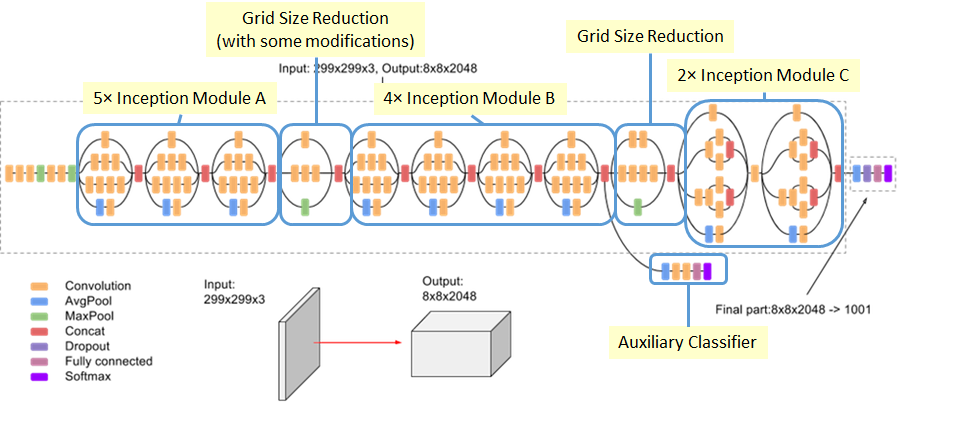

Inception-v3 is a convolutional neural network that is 48 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299.

<font size="+2" color="indigo"><b>5.2 ResNet 50</b></font><br><a id="5.2"></a>

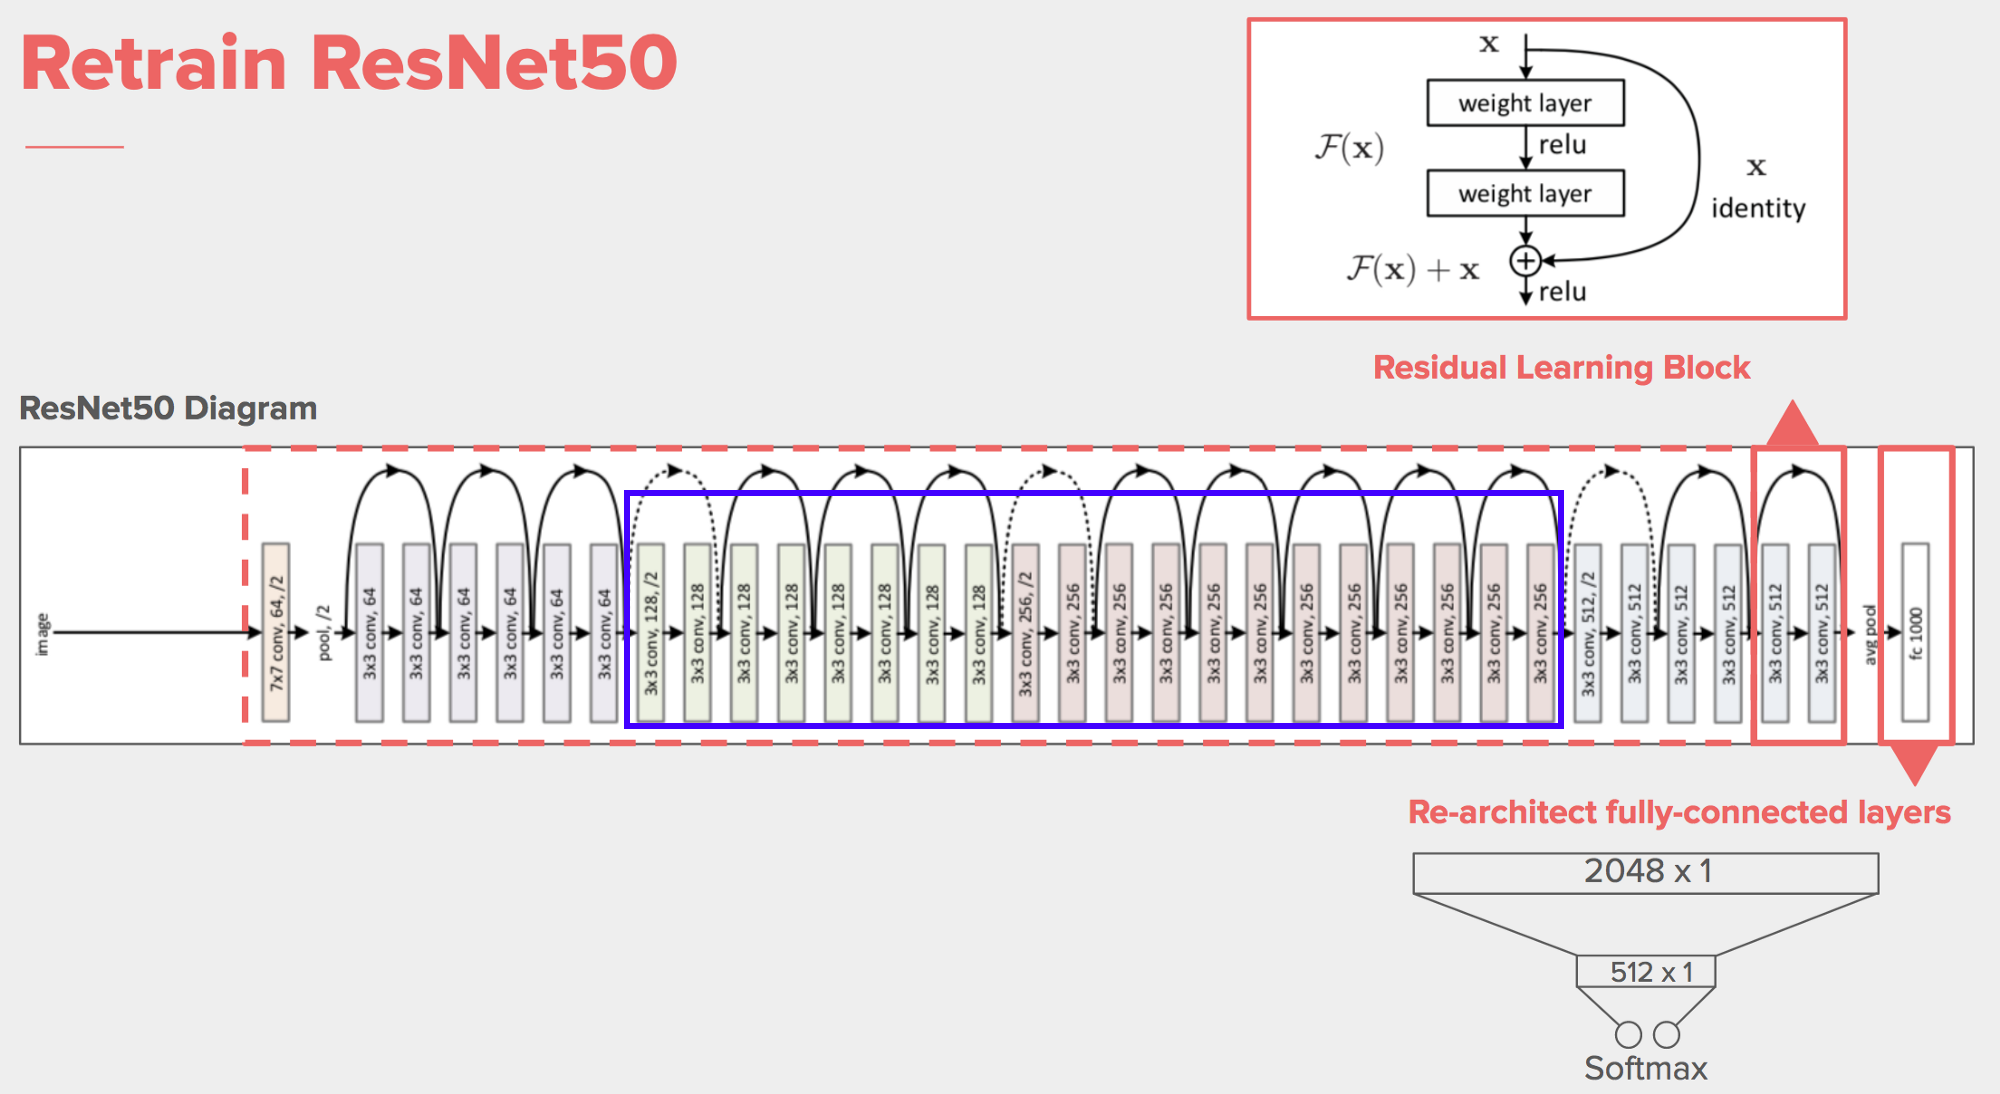

ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.
AlexNet, the winner of ImageNet 2012 and the model that apparently kick started the focus on deep learning had only 8 convolutional layers, the VGG network had 19 and Inception or GoogleNet had 22 layers and ResNet 152 had 152 layers. In this blog we will code a ResNet-50 that is a smaller version of ResNet 152 and frequently used as a starting point for transfer learning.

<font size="+2" color="indigo"><b>5.3 VGG 16</b></font><br><a id="5.3"></a>

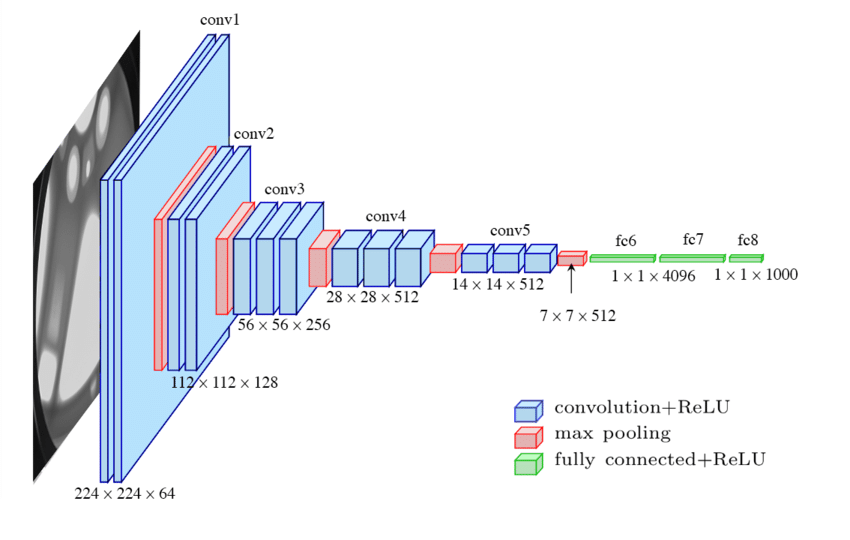

The input to conv1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center). In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv.  layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). The final layer is the soft-max layer. The configuration of the fully connected layers is the same in all networks.

All hidden layers are equipped with the rectification (ReLU) non-linearity. It is also noted that none of the networks (except for one) contain Local Response Normalisation (LRN), such normalization does not improve the performance on the ILSVRC dataset, but leads to increased memory consumption and computation time.

<font size="+3" color="blue"><b>6. Implementing the Architectures with little Fine tuning </b></font><br> <a id="6"></a>

<font size="+2" color="indigo"><b>6.1 Implementing Inception V3</b></font><br><a id="6.1"></a>

In [7]:
local_weights_file = '/kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x)

last layer output shape:  (None, 7, 7, 768)


In [9]:
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [10]:
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

439/439 [==============================] - 415s 946ms/step - loss: 0.4130 - acc: 0.8675 - val_loss: 0.2774 - val_acc: 0.9093


<font size="+2" color="indigo"><b>6.1 Implementing ResNet 50 (using ImageNet) </b></font><br><a id="6.2"></a>

In [11]:
from tensorflow.keras.applications import ResNet50

pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights='imagenet'
                                   )

for layer in pretrained_model.layers:
     layer.trainable = False

pretrained_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

In [12]:
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

model_resnet = Model(pretrained_model.input, x) 

last layer of vgg : output shape:  (None, 5, 5, 2048)


In [13]:
model_resnet.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [14]:
model_resnet.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

439/439 [==============================] - 778s 2s/step - loss: 1.4614 - acc: 0.4235 - val_loss: 1.2638 - val_acc: 0.4183


<font size="+2" color="indigo"><b>6.3 Implementing VGG 16 </b></font><br><a id="6.3"></a>

In [18]:
from tensorflow.keras.applications import VGG16
file='/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights =None)

pretrained_model.load_weights(file)

for layer in pretrained_model.layers:
     layer.trainable = False

In [19]:
last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 

last layer of vgg : output shape:  (None, 4, 4, 512)


In [ ]:
model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

#model_vgg.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

<font size="+2" color="blue"><b>7. Acknowledgement and Sources of Inspiration for the Kernels </b></font><br><a id="7"></a>

A big Thankyou to @raenish for making such an awesome theme for the notebooks.
- https://www.kaggle.com/janvichokshi/transfer-learning-cnn-resnet-vgg16-iceptionv3
- https://www.kaggle.com/raenish/cheatsheet-text-helper-functions
- https://www.kaggle.com/keras/inceptionv3
- https://www.kaggle.com/keras/resnet50
- https://www.kaggle.com/keras/vgg16

<font size="+2" color="chocolate"><b>My Other Kernels</b></font><br>

#### Click on the button to view kernels...


<a href="https://www.kaggle.com/darthmanav/explaining-resnet-model-fine-tuning-pca-t-sne" class="btn btn-primary" style="color:white;">Explaining ResNet architecture</a>

<a href="https://www.kaggle.com/darthmanav/explaining-alexnet-model-tutorial-fine-tuning-pca" class="btn btn-primary" style="color:white;">Explaining AlexNet architecture</a>

<a href="https://www.kaggle.com/darthmanav/multilayer-perceptron-fine-tuning-pca-t-sne-mnist" class="btn btn-primary" style="color:white;">Explaining Multi layer Perceptron architecture</a>

<a href="https://www.kaggle.com/darthmanav/explaining-vgg-model-fine-tuning-pca-t-sne" class="btn btn-primary" style="color:white;">Explaining VGG architecture</a>

<a href="https://www.kaggle.com/darthmanav/predicting-wine-quality-using-svm-knn-with-eda" class="btn btn-primary" style="color:white;">Wine Quality using SVM,KNN</a>

<a href="https://www.kaggle.com/darthmanav/glove-lstm-sentiment-analysis-for-beginners" class="btn btn-primary" style="color:white;">NLP tutorial on Glove and LSTM</a>

<a href="https://www.kaggle.com/darthmanav/horse-vs-human-classification-by-resnet50-beginner" class="btn btn-primary" style="color:white;">Horse Vs Humans</a>

<br>

###  If these kernels impress you,give them an <font size="+2" color="red"><b>Upvote</b></font>.<br>
<a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>